Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [21]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from keras import Sequential
from keras.layers import BatchNormalization
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Rescaling
from keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation, RandomCrop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.preprocessing import image_dataset_from_directory
from glob import glob
#!pip install Augmentor
import Augmentor
from sklearn.metrics import confusion_matrix, accuracy_score

In [22]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [23]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/ColabNotebooks/Jithendra-Melanoma-Detection-Assignment-main/Images/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/ColabNotebooks/Jithendra-Melanoma-Detection-Assignment-main/Images/Test')

In [24]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [25]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [26]:
train_ds, val_ds = image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="both",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


test_ds = image_dataset_from_directory(
  data_dir_test,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Using 447 files for validation.
Found 118 files belonging to 9 classes.


In [27]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

num_classes = len(class_names)

print(num_classes)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
9


### Visualize the data


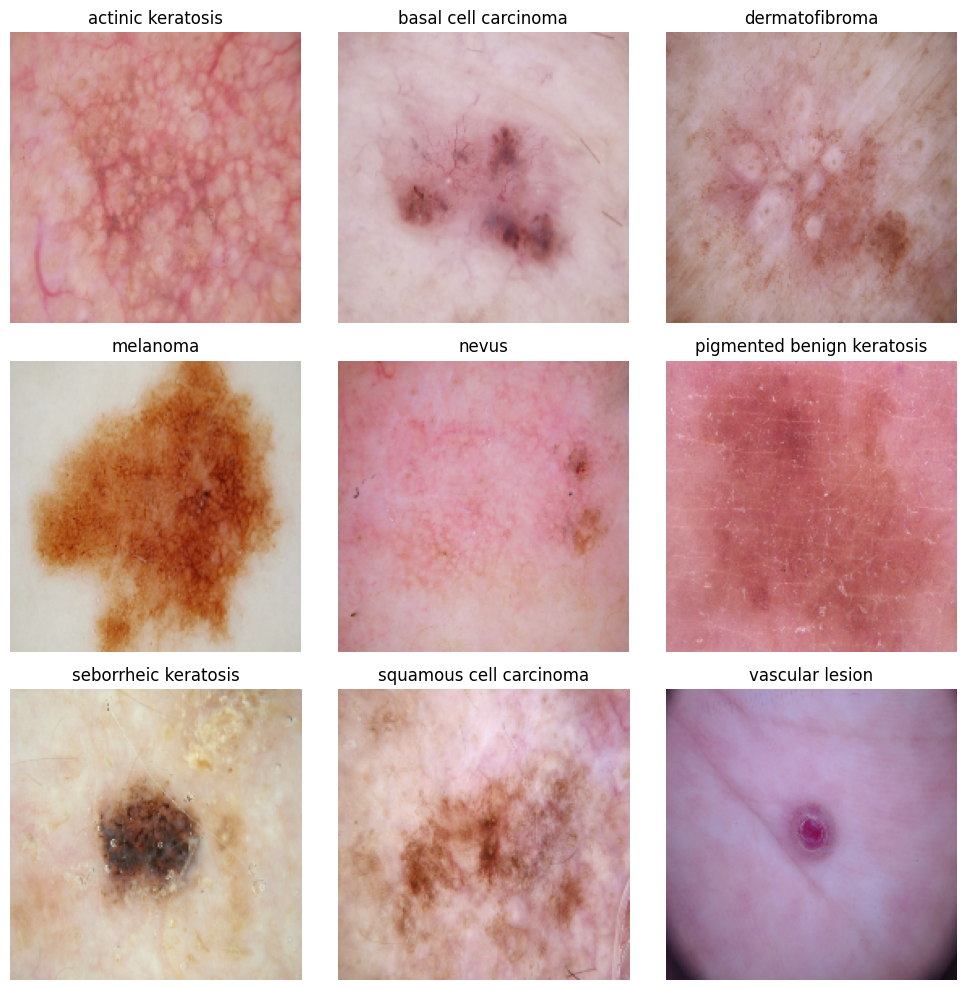

In [28]:
image_dict = {}
total_classes = len(class_names)

for batch_images, batch_labels in train_ds.take(10):
    for j in range(batch_images.shape[0]):
        current_label = batch_labels[j].numpy()
        category_name = class_names[current_label]
        if category_name not in image_dict:
            image_dict[category_name] = batch_images[j].numpy().astype("uint8")
        if len(image_dict) == total_classes:
            break
    if len(image_dict) == total_classes:
        break

sorted_categories = sorted(image_dict.keys())
sorted_images_list = [image_dict[category] for category in sorted_categories]

plt.figure(figsize=(10, 10))
for k in range(len(sorted_images_list)):
    ax = plt.subplot(3, 3, k + 1)
    plt.imshow(sorted_images_list[k])
    plt.title(sorted_categories[k])
    plt.axis("off")
plt.tight_layout()
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [29]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
####  Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [30]:
model = Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  Conv2D(16, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes)
])


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [31]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
# View the summary of all layers
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [33]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.2007 - loss: 2.4025 - val_accuracy: 0.2864 - val_loss: 1.9544
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.2818 - loss: 1.9328 - val_accuracy: 0.3915 - val_loss: 1.7720
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.3929 - loss: 1.6861 - val_accuracy: 0.4989 - val_loss: 1.4560
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.5163 - loss: 1.3930 - val_accuracy: 0.5078 - val_loss: 1.4043
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.5417 - loss: 1.2445 - val_accuracy: 0.4787 - val_loss: 1.4717
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.5691 - loss: 1.2510 - val_accuracy: 0.5213 - val_loss: 1.3742
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.6039 - loss: 1.1370 - val_accuracy: 0.5078 - val_loss: 1.3956
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.6216 - loss: 1.0674 - val_accuracy: 0.5190 - val_loss

### Visualizing training results

In [34]:
def VisualizeResults(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

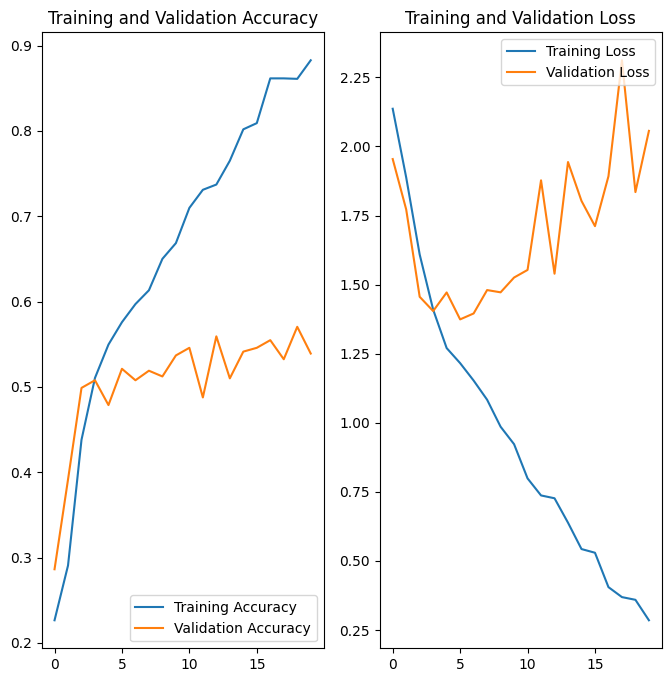

In [35]:
VisualizeResults(history)

#### The evidence points towards overfitting in this model. While it achieves high accuracy on the training set, its performance on the validation set does not reflect a similar improvement.

In [36]:
 # This is Overfitting. I am going to use augmentations: Random Flip, Random Rotation,Random Zoom, Random Translation, RandomCrop.
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomTranslation(height_factor=0.1, width_factor=0.1),
    RandomCrop(height=img_height, width=img_width)
])

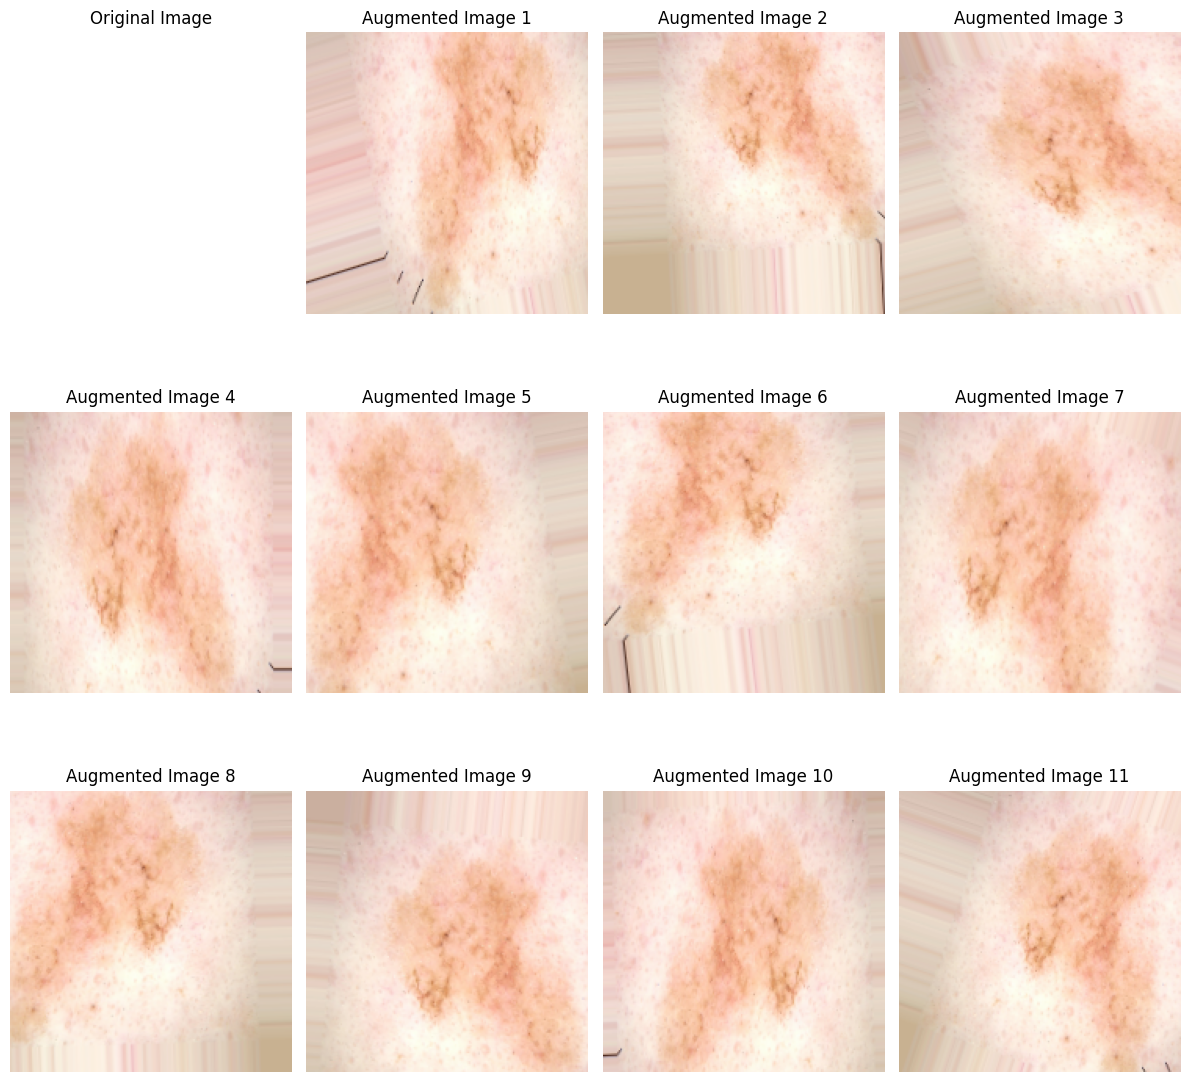

In [37]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here


sample_image, sample_label = next(iter(train_ds))
image_to_augment = sample_image[0].numpy()

data_gen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
)

image_to_augment = np.expand_dims(image_to_augment, axis=0)

augmented_images = data_gen.flow(image_to_augment, batch_size=1)

plt.figure(figsize=(12, 12))
plt.subplot(3, 4, 1)
plt.imshow(image_to_augment[0])
plt.title("Original Image")
plt.axis("off")

for i in range(1, 12):
    augmented_image = next(augmented_images)[0].astype("uint8")
    plt.subplot(3, 4, i + 1)
    plt.imshow(augmented_image)
    plt.title(f"Augmented Image {i}")
    plt.axis("off")

plt.tight_layout()
plt.show()


### Create the model, compile and train the model


In [38]:
model = Sequential([
    Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes)
])



### Compiling the model

In [39]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [41]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.1736 - loss: 2.2567 - val_accuracy: 0.3020 - val_loss: 1.9691
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.2708 - loss: 1.9725 - val_accuracy: 0.2058 - val_loss: 1.9876
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.3163 - loss: 1.8413 - val_accuracy: 0.4564 - val_loss: 1.6413
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.3942 - loss: 1.7033 - val_accuracy: 0.4743 - val_loss: 1.5016
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.4147 - loss: 1.6288 - val_accuracy: 0.5369 - val_loss: 1.4656
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.5132 - loss: 1.4772 - val_accuracy: 0.5414 - val_loss: 1.4307
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.4950 - loss: 1.4524 - val_accuracy: 0.5302 - val_loss: 1.4259
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.5178 - loss: 1.4217 - val_accuracy: 0.5235 - val_loss:

### Visualizing the results

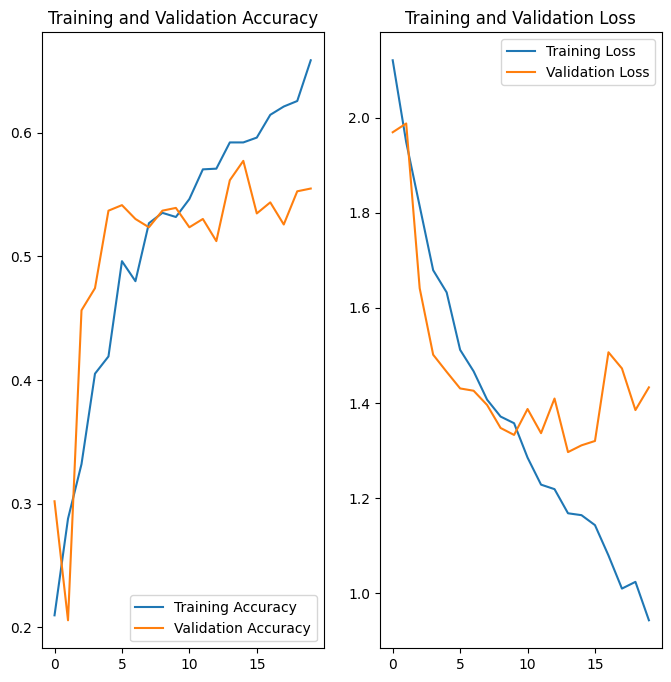

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Compared to the initial model run, there is a clear improvement. The accuracy in that run was much lower. Although the validation accuracy in this iteration is still lacking, the training loss shows that the model is learning more effectively. The positive trend in training loss indicates that the model is headed in the right direction, even if the validation performance falls short of expectations.

####  Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [43]:
### Helper function to count the files for classes

def CountImagesForClasses(dir_train):
    dirs = [f for f in dir_train.iterdir() if f.is_dir()]
    dicDir = {}

    for dir in dirs:
        currdir = pathlib.Path(os.path.join(data_dir_train, dir))

        cnt = len(list(currdir.rglob("*.jpg")))
        dicDir[currdir.name] = cnt

    df = pd.DataFrame(dicDir.items(), columns=['Class', 'Number'])
    return df

                        Class  Number
0           actinic keratosis     114
1                    melanoma     438
2        seborrheic keratosis      77
3     squamous cell carcinoma     181
4             vascular lesion     139
5  pigmented benign keratosis     462
6              dermatofibroma      95
7        basal cell carcinoma     376
8                       nevus     357


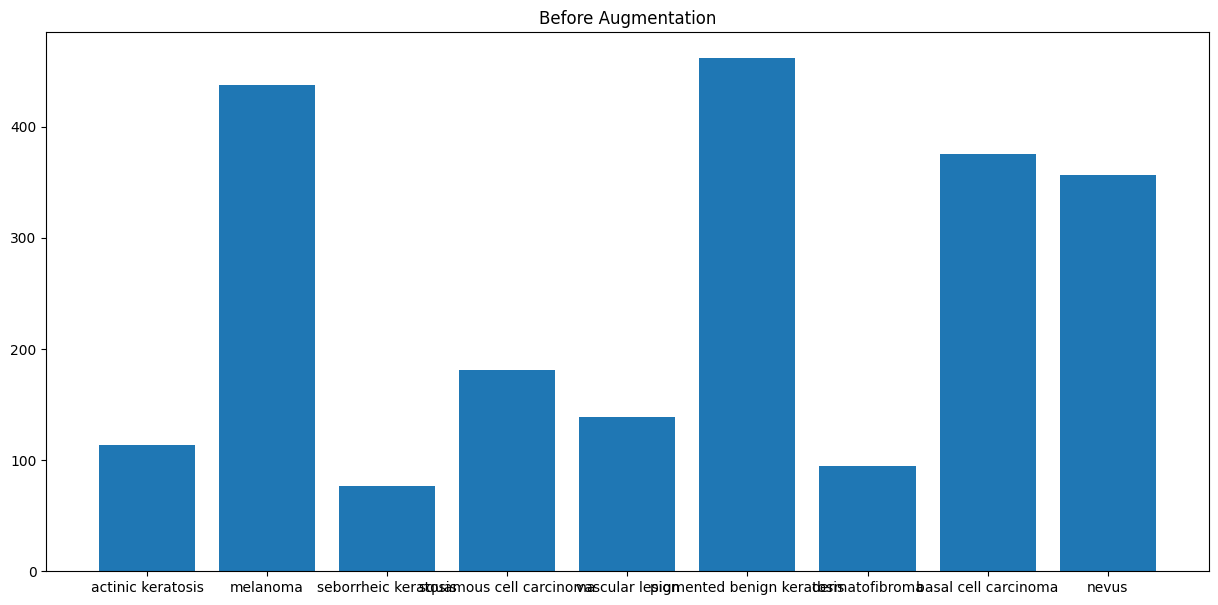

In [44]:
dfClasses = CountImagesForClasses(data_dir_train)

print(dfClasses)

plt.figure(figsize=(15,7))
plt.title("Before Augmentation")
plt.bar(data=dfClasses, x="Class", height="Number")
plt.show()

####  
#### - Which class has the least number of samples?
*   Seborrheic Keratosis has the least number of samples, with only 77 samples.

#### - Which classes dominate the data in terms proportionate number of samples?
*   Dominant Classes:     

    *   Pigmented Benign Keratosis (462 samples)
    *   Melanoma (438 samples)
    *   Basal Cell Carcinoma (376 samples).





####  Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [46]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [47]:

for i in class_names:
    p = Augmentor.Pipeline(data_dir_train.joinpath( i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/ColabNotebooks/Jithendra-Melanoma-Detection-Assignment-main/Images/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A52629201F0>: 100%|██████████| 500/500 [00:38<00:00, 13.10 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/ColabNotebooks/Jithendra-Melanoma-Detection-Assignment-main/Images/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A526153D0C0>: 100%|██████████| 500/500 [00:28<00:00, 17.30 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/ColabNotebooks/Jithendra-Melanoma-Detection-Assignment-main/Images/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A5262A6DAB0>: 100%|██████████| 500/500 [00:28<00:00, 17.72 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/ColabNotebooks/Jithendra-Melanoma-Detection-Assignment-main/Images/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A5262EE1000>: 100%|██████████| 500/500 [01:50<00:00,  4.51 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/ColabNotebooks/Jithendra-Melanoma-Detection-Assignment-main/Images/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7A5262F05E40>: 100%|██████████| 500/500 [01:34<00:00,  5.27 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/ColabNotebooks/Jithendra-Melanoma-Detection-Assignment-main/Images/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A527926AB90>: 100%|██████████| 500/500 [00:27<00:00, 17.91 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/ColabNotebooks/Jithendra-Melanoma-Detection-Assignment-main/Images/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A52629201F0>: 100%|██████████| 500/500 [00:53<00:00,  9.39 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/ColabNotebooks/Jithendra-Melanoma-Detection-Assignment-main/Images/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A527C8D02B0>: 100%|██████████| 500/500 [00:28<00:00, 17.75 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/ColabNotebooks/Jithendra-Melanoma-Detection-Assignment-main/Images/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A527BB5E9B0>: 100%|██████████| 500/500 [00:26<00:00, 18.87 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [48]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [49]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/ColabNotebooks/Jithendra-Melanoma-Detection-Assignment-main/Images/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026040.jpg_78a4dbea-23a9-4fb8-9d1d-0ebbbde04c3b.jpg',
 '/content/drive/MyDrive/ColabNotebooks/Jithendra-Melanoma-Detection-Assignment-main/Images/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028063.jpg_95cd8929-5b30-4813-a777-6c3e9f6b49d3.jpg',
 '/content/drive/MyDrive/ColabNotebooks/Jithendra-Melanoma-Detection-Assignment-main/Images/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030142.jpg_31038dcd-7b7e-46de-8ead-d1f58ca78600.jpg',
 '/content/drive/MyDrive/ColabNotebooks/Jithendra-Melanoma-Detection-Assignment-main/Images/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027615.jpg_f5ee8930-f6f2-4062-8183-a42590b23338.jpg',
 '/content/drive/MyDrive/ColabNotebooks/Jithendra-Melanoma-Detection-Assignment-main/Images/Train/actinic keratosis/output/actinic keratosis_original_ISIC_00269

In [50]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [51]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

####  Train the model on the data created using Augmentor

In [52]:
batch_size = 32
img_height = 180
img_width = 180

####   Create a training dataset

In [62]:
train_ds, val_ds = image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="both",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Using 1347 files for validation.


####   Create your model (make sure to include normalization)

In [63]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  Rescaling(1./255),
  Conv2D(16, 3, padding='same', activation='relu'),
  BatchNormalization(),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  BatchNormalization(),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  BatchNormalization(),
  MaxPooling2D(),
  Dropout(0.2),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes, activation='softmax')
])

####   Compile your model (Choose optimizer and loss function appropriately)

In [64]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

####    Train your model

In [65]:
epochs = 30

trainHistory = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 ━━━━━━━━━━━━━━━━━━━━ 385s 2s/step - accuracy: 0.2746 - loss: 3.6102 - val_accuracy: 0.1032 - val_loss: 24.9710
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 314s 2s/step - accuracy: 0.4122 - loss: 1.4815 - val_accuracy: 0.1952 - val_loss: 12.0935
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - accuracy: 0.5135 - loss: 1.2549 - val_accuracy: 0.3779 - val_loss: 2.0930
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - accuracy: 0.5650 - loss: 1.1124 - val_accuracy: 0.4684 - val_loss: 1.4485
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.6233 - loss: 0.9621 - val_accuracy: 0.5887 - val_loss: 1.0917
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 345s 2s/step - accuracy: 0.6798 - loss: 0.8378 - val_accuracy: 0.5687 - val_loss: 1.2096
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - accuracy: 0.7388 - loss: 0.6935 - val_accuracy: 0.5999 - val_loss: 1.1279
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 304s 2s/step - accuracy: 0.7961 - loss: 0.5418 - val_accuracy: 0.5

####    Visualize the model results

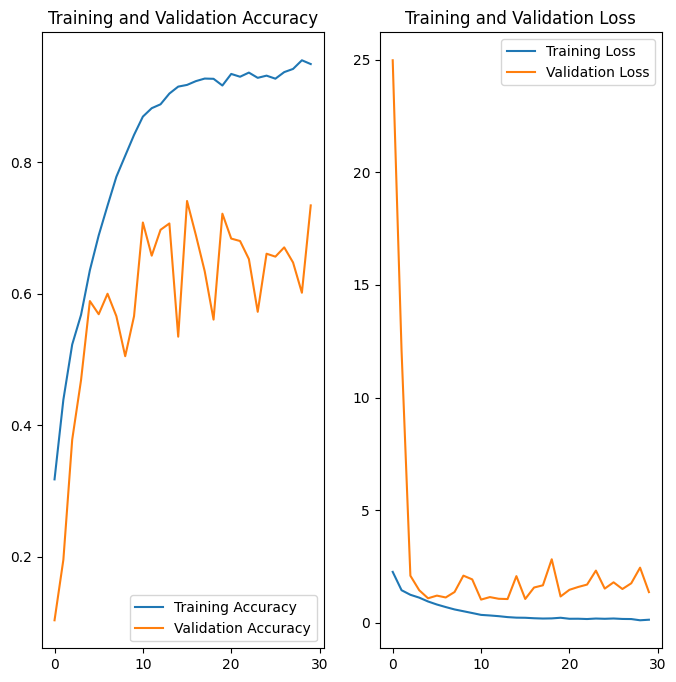

In [66]:
VisualizeResults(trainHistory)

####  **Analysis of results**


*   The training accuracy rose significantly from approximately 27% in the first epoch to around 95% by the end of training, indicating effective learning.
Validation accuracy improved from around 30% in the second model to a peak of about 74% in the third model, demonstrating better generalization.
*   The validation loss showed a reduction overall, stabilizing at lower values, which indicates that the model is learning more effectively and not just memorizing the training data.
*   The training and validation metrics showed a more consistent learning pattern without the initial spikes seen in earlier models.
*   The initial models exhibited signs of underfitting, particularly in the first model, where low accuracy indicated that the model was not capturing underlying patterns. By the third model, this issue appears to have been addressed, as training accuracy improved significantly.
*   Class rebalancing likely contributed to these improvements by providing a more equitable distribution of samples from each class, allowing the model to learn representative features more effectively. This reduction in class imbalance helps prevent the model from being biased towards majority classes, thus enhancing its ability to recognize patterns from minority classes.  



### Run on Test Data

In [67]:
predictions = model.predict(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step


In [68]:
prediction_classes = np.argmax(predictions, axis=1)

prediction_classes

array([0, 4, 5, 1, 3, 1, 5, 4, 4, 1, 1, 0, 1, 4, 2, 1, 5, 4, 4, 5, 5, 1,
       4, 7, 0, 2, 4, 4, 0, 4, 5, 4, 7, 3, 4, 4, 5, 5, 4, 1, 8, 8, 4, 5,
       5, 3, 5, 1, 4, 4, 4, 7, 4, 2, 2, 1, 8, 7, 1, 0, 2, 5, 4, 5, 5, 1,
       4, 0, 7, 5, 0, 2, 5, 7, 4, 0, 4, 7, 1, 7, 5, 3, 4, 4, 5, 3, 3, 7,
       5, 1, 5, 1, 4, 5, 1, 4, 4, 5, 4, 4, 4, 7, 4, 7, 0, 3, 6, 1, 3, 1,
       3, 7, 0, 2, 0, 1, 5, 5])

In [69]:
test_classes = [item[1] for item in test_ds.as_numpy_iterator()]

test_classes = np.concatenate(test_classes)

test_classes

array([0, 4, 7, 2, 4, 1, 3, 4, 4, 1, 7, 0, 1, 4, 2, 2, 3, 3, 2, 7, 4, 1,
       3, 5, 0, 5, 3, 0, 0, 5, 5, 1, 5, 5, 2, 3, 4, 7, 7, 6, 8, 8, 2, 0,
       5, 3, 5, 1, 3, 3, 4, 1, 0, 2, 2, 0, 8, 7, 1, 0, 2, 3, 4, 7, 1, 5,
       2, 5, 7, 0, 0, 2, 5, 1, 4, 7, 4, 1, 2, 2, 5, 3, 3, 0, 7, 2, 3, 0,
       3, 1, 5, 5, 4, 7, 1, 4, 4, 5, 2, 7, 7, 0, 4, 7, 7, 6, 6, 1, 3, 2,
       3, 0, 7, 5, 0, 1, 4, 1], dtype=int32)

In [70]:
cm = confusion_matrix(test_classes, prediction_classes)

print(cm)

[[ 7  1  0  0  3  2  0  3  0]
 [ 0 10  0  0  1  2  0  3  0]
 [ 0  4  5  1  5  0  0  1  0]
 [ 0  0  0  5  7  4  0  0  0]
 [ 0  0  0  1 12  3  0  0  0]
 [ 1  2  2  1  1  7  0  2  0]
 [ 0  1  0  1  0  0  1  0  0]
 [ 3  1  0  0  3  6  0  3  0]
 [ 0  0  0  0  0  0  0  0  3]]
